In [1]:
import cartopy.crs as ccrs
import dask
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import momlevel as ml
import numpy as np
import scipy.signal as signal
import xarray as xr

dask.config.set(**{"array.slicing.split_large_chunks": False})

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [2]:
path_data = "/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/"

In [49]:
for i in range(0, 5):
    ds = xr.open_mfdataset(f"{path_data}ocean_monthly_1x1deg.0{i}*hf*.nc", use_cftime=True)
    ds_out = (ds.hflso + ds.hfsso).to_dataset(name="hf_turb")#.sel(lat=slice(-90, -30))
    ds_out.to_netcdf(f"{path_data}ocean_monthly_1x1deg.0{i}01-0{i+1}00.hf_turb.nc")
    print(i)

OSError: no files to open

In [4]:
ds = xr.open_mfdataset(f"{path_data}ocean_monthly_1x1deg.*.hf_turb.nc")

da_out = ml.trend.linear_detrend(ds.hf_turb, mode='correct')
ds_out = da_out.to_dataset(name="hf_turb").chunk({"lat": 30, "lon": 48, "time": 18250})
ds_out.to_zarr(
    f"/xtmp/Katherine.Turner/work/storm_timeseries/ESM4_cmip_hf_turb_detrended_ocean"
)

In [6]:
# comparing hf_turb calculations

ds1 = xr.open_mfdataset(f"{path_data}atmos_cmip.*.hf_turb.nc")
ds2 = xr.open_mfdataset(f"{path_data}ocean_monthly_1x1deg.*.hf_turb.nc")

ds1_dt = xr.open_zarr("/xtmp/Katherine.Turner/work/storm_timeseries/ESM4_cmip_hf_turb_detrended_atmos")
ds2_dt = xr.open_zarr("/xtmp/Katherine.Turner/work/storm_timeseries/ESM4_cmip_hf_turb_detrended_ocean")

da1_jja = ds1.hf_turb.groupby(ds1.time.dt.season).mean().sel(season='JJA')
da2_jja = ds2.hf_turb.groupby(ds2.time.dt.season).mean().sel(season='JJA')

da1_dt_jja = ds1_dt.hf_turb.groupby(ds1_dt.time.dt.season).mean().sel(season='JJA')
da2_dt_jja = ds2_dt.hf_turb.groupby(ds2_dt.time.dt.season).mean().sel(season='JJA')

da1_djf = ds1.hf_turb.groupby(ds1.time.dt.season).mean().sel(season='DJF')
da2_djf = ds2.hf_turb.groupby(ds2.time.dt.season).mean().sel(season='DJF')

da1_dt_djf = ds1_dt.hf_turb.groupby(ds1_dt.time.dt.season).mean().sel(season='DJF')
da2_dt_djf = ds2_dt.hf_turb.groupby(ds2_dt.time.dt.season).mean().sel(season='DJF')

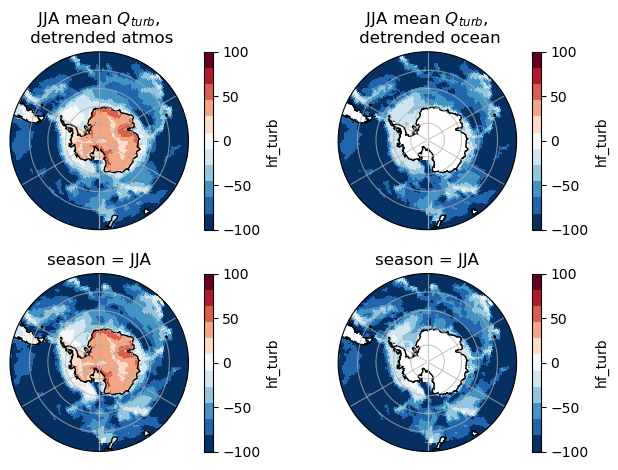

In [9]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
    figsize=(7, 4.8),
)

axs = axs.flatten()

(-1 * da1_jja).plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=-100,
    vmax=100,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[0].set_title("JJA mean $Q_{turb}$, \n atmos")

(da2_jja).plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmin=-100,
    vmax=100,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[1].set_title("JJA mean $Q_{turb}$, \n ocean")

(-1 * da1_dt_jja).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    vmin=-100,
    vmax=100,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[0].set_title("JJA mean $Q_{turb}$, \n detrended atmos")

(da2_dt_jja).plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    vmin=-100,
    vmax=100,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[1].set_title("JJA mean $Q_{turb}$, \n detrended ocean")

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

In [ ]:
(-1 * (hf_turb_mean[idx_hi_jja_storms, :, :].mean(dim="time") - hf_turb_mean_jja)).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[2].set_title("$\Delta$ JJA $Q_{turb}$, \n low storm seasons")

(-1 * hf_turb_mean_djf).plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    vmin=-50,
    vmax=50,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[3].set_title("DJF mean $Q_{turb}$, \n W m$^{-2}$")

(-1 * (hf_turb_mean[idx_lo_djf_storms, :, :].mean(dim="time") - hf_turb_mean_djf)).plot(
    ax=axs[4],
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[4].set_title("$\Delta$ DJF $Q_{turb}$, \n high storm seasons")

(-1 * (hf_turb_mean[idx_hi_djf_storms, :, :].mean(dim="time") - hf_turb_mean_djf)).plot(
    ax=axs[5],
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[5].set_title("$\Delta$ DJF $Q_{turb}$, \n low storm seasons")



## Creating bandpassed signals

In [27]:
ds = xr.open_zarr(
    f"/xtmp/Katherine.Turner/work/storm_timeseries/ESM4_cmip_hf_turb_detrended"
)
ds_static = xr.open_dataset(
    "/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/atmos.static.nc"
)

In [28]:
ts_shape = ds.hf_turb.shape

mask = (ds_static.land_mask < 0.3)[:60, :]
mask = mask.load()

In [29]:
filtered = np.ones(shape=ts_shape) * np.nan
sos = signal.butter(4, 0.125, "highpass", fs=1, output="sos")

for i in range(10, 60):
    for j in range(288):
        if mask[i, j] == 1:
            sig = ds.hf_turb[:, i, j].data
            filtered[:, i, j] = signal.sosfilt(sos, sig)
    if i % 10 == 0:
        print(i)

10
20
30
40
50


In [30]:
ds_out = xr.Dataset(
    data_vars=dict(
        hf_turb_hp_8d=(["time", "lat", "lon"], filtered),
    ),
    coords=dict(
        lon=("lon", ds.lon.data),
        lat=("lat", ds.lat.data),
        time=ds.time.data,
    ),
    attrs=dict(description=f"Highpass-filtered hf_turb for ESM4 500-year run in W m-2"),
)

ds_out = ds_out.chunk({"time": 34675, "lon": 48})
ds_out.to_zarr(
    f"/xtmp/Katherine.Turner/work/storm_timeseries/ESM4_cmip_hf_turb_highpassed_syn"
)

## Analyzing correlations between seasonal means, variance, and high-frequency fraction of variance against storm numbers

In [14]:
ds_full = xr.open_zarr(
    f"/xtmp/Katherine.Turner/work/storm_timeseries/{mod}_cmip_hf_turb_detrended_ocean"
)
#ds_hf = xr.open_zarr(
#    f"/xtmp/Katherine.Turner/work/storm_timeseries/{mod}_cmip_hf_turb_highpassed_syn"
#)

In [15]:
ds_static = xr.open_dataset(
    f"/work/Katherine.Turner/tempest-extremes/{mod}_cmip/data/atmos.static.nc"
)
mask = (ds_static.land_mask < 0.3)[:60, :]

In [17]:
hf_turb_mean = ds_full.hf_turb.resample(time="QS-DEC").mean()
hf_turb_std = ds_full.hf_turb.resample(time="QS-DEC").std() * mask
hf_turb_var = ds_full.hf_turb.resample(time="QS-DEC").var() * mask
#hf_turb_var_syn = ds_hf.hf_turb_hp_8d.resample(time="QS-DEC").var() * mask

In [18]:
idx_jja = hf_turb_mean.time.dt.month == 6
idx_djf = hf_turb_mean.time.dt.month == 12

hf_turb_mean_jja = hf_turb_mean[idx_jja, :, :].mean(dim="time")
hf_turb_var_jja = hf_turb_var[idx_jja, :, :].mean(dim="time")
hf_turb_std_jja = hf_turb_std[idx_jja, :, :].mean(dim="time")
#hf_turb_var_syn_jja = hf_turb_var_syn[idx_jja, :, :].mean(dim="time")

hf_turb_mean_djf = hf_turb_mean[idx_djf, :, :].mean(dim="time")
hf_turb_var_djf = hf_turb_var[idx_djf, :, :].mean(dim="time")
hf_turb_std_djf = hf_turb_std[idx_djf, :, :].mean(dim="time")
#hf_turb_var_syn_djf = hf_turb_var_syn[idx_djf, :, :].mean(dim="time")

In [19]:
mod = "ESM4"
ds_storms = xr.open_dataset(
    f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_cmip_monthly_storms.nc"
)
seasonal_storms = ds_storms.resample(time="QS-DEC").sum()

idx_djf = seasonal_storms.time.dt.month == 12
idx_jja = seasonal_storms.time.dt.month == 6

storms_djf = seasonal_storms.center_counts[idx_djf][1:-1]
storms_jja = seasonal_storms.center_counts[idx_jja]

In [20]:
lo_jja_storms = storms_jja.sortby(storms_jja).time.dt.year[:50]
hi_jja_storms = storms_jja.sortby(storms_jja).time.dt.year[-50:]

lo_djf_storms = storms_djf.sortby(storms_jja).time.dt.year[:50]
hi_djf_storms = storms_djf.sortby(storms_jja).time.dt.year[-50:]

In [21]:
idx_lo_jja_storms = hf_turb_mean.time.dt.month.isin(
    [6]
) & hf_turb_mean.time.dt.year.isin(lo_jja_storms)
idx_hi_jja_storms = hf_turb_mean.time.dt.month.isin(
    [6]
) & hf_turb_mean.time.dt.year.isin(hi_jja_storms)

idx_lo_djf_storms = hf_turb_mean.time.dt.month.isin(
    [12]
) & hf_turb_mean.time.dt.year.isin(lo_djf_storms)
idx_hi_djf_storms = hf_turb_mean.time.dt.month.isin(
    [12]
) & hf_turb_mean.time.dt.year.isin(hi_djf_storms)

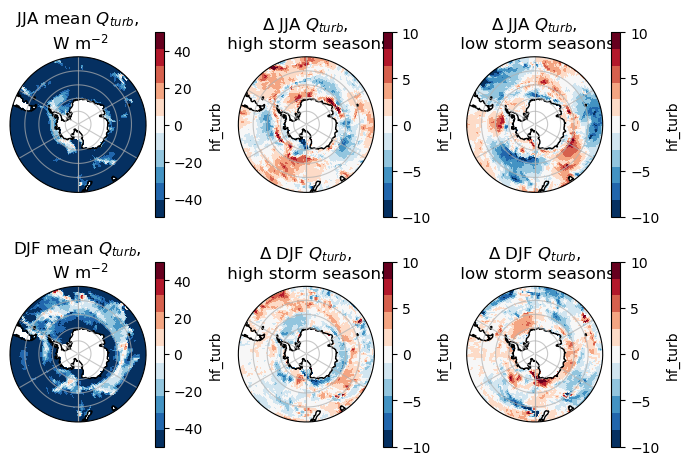

In [23]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
    figsize=(7, 4.8),
)

axs = axs.flatten()

(hf_turb_mean_jja).plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=-50,
    vmax=50,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[0].set_title("JJA mean $Q_{turb}$, \n W m$^{-2}$")

((hf_turb_mean[idx_lo_jja_storms, :, :].mean(dim="time") - hf_turb_mean_jja)).plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[1].set_title("$\Delta$ JJA $Q_{turb}$, \n high storm seasons")

((hf_turb_mean[idx_hi_jja_storms, :, :].mean(dim="time") - hf_turb_mean_jja)).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[2].set_title("$\Delta$ JJA $Q_{turb}$, \n low storm seasons")

(hf_turb_mean_djf).plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    vmin=-50,
    vmax=50,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[3].set_title("DJF mean $Q_{turb}$, \n W m$^{-2}$")

((hf_turb_mean[idx_lo_djf_storms, :, :].mean(dim="time") - hf_turb_mean_djf)).plot(
    ax=axs[4],
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[4].set_title("$\Delta$ DJF $Q_{turb}$, \n high storm seasons")

((hf_turb_mean[idx_hi_djf_storms, :, :].mean(dim="time") - hf_turb_mean_djf)).plot(
    ax=axs[5],
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[5].set_title("$\Delta$ DJF $Q_{turb}$, \n low storm seasons")

for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

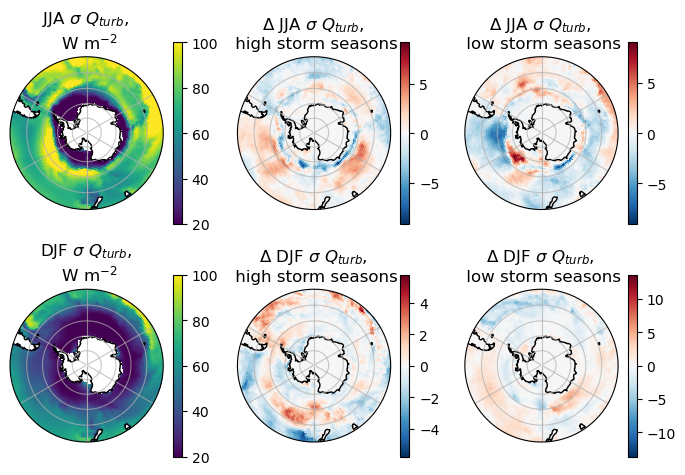

In [19]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
    figsize=(7, 4.8),
)

axs = axs.flatten()

xr.where(hf_turb_std_jja == 0, np.nan, hf_turb_std_jja).plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=20,
    vmax=100,
    extend="neither",
    # cmap=plt.get_cmap('RdBu_r', 11),
)
axs[0].set_title("JJA $\sigma$ $Q_{turb}$, \n W m$^{-2}$")

(hf_turb_std[idx_lo_jja_storms, :, :].mean(dim="time") - hf_turb_std_jja).plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    # vmin=-10, vmax=10,
    # extend='neither',
    # cmap=plt.get_cmap('RdBu_r',11),
)
axs[1].set_title("$\Delta$ JJA $\sigma$ $Q_{turb}$, \n high storm seasons")

(hf_turb_std[idx_hi_jja_storms, :, :].mean(dim="time") - hf_turb_std_jja).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    # vmin=-10, vmax=10,
    # extend='neither',
    # cmap=plt.get_cmap('RdBu_r',11),
)
axs[2].set_title("$\Delta$ JJA $\sigma$ $Q_{turb}$, \n low storm seasons")

xr.where(hf_turb_std_djf == 0, np.nan, hf_turb_std_djf).plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    vmin=20,
    vmax=100,
    extend="neither",
    # cmap=plt.get_cmap('RdBu_r', 11),
)
axs[3].set_title("DJF $\sigma$ $Q_{turb}$, \n W m$^{-2}$")

(hf_turb_std[idx_lo_djf_storms, :, :].mean(dim="time") - hf_turb_std_djf).plot(
    ax=axs[4],
    transform=ccrs.PlateCarree(),
    # vmin=-10, vmax=10,
    # extend='neither',
    # cmap=plt.get_cmap('RdBu_r',11),
)
axs[4].set_title("$\Delta$ DJF $\sigma$ $Q_{turb}$, \n high storm seasons")

((hf_turb_std[idx_hi_djf_storms, :, :].mean(dim="time") - hf_turb_std_djf)).plot(
    ax=axs[5],
    transform=ccrs.PlateCarree(),
    # vmin=-10, vmax=10,
    # extend='neither',
    # cmap=plt.get_cmap('RdBu_r',11),
)
axs[5].set_title("$\Delta$ DJF $\sigma$ $Q_{turb}$, \n low storm seasons")

for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

In [41]:
synfrac_jja = (hf_turb_var_syn[idx_jja, :, :] / hf_turb_var[idx_jja, :, :]).mean(
    dim="time"
)
synfrac_djf = (hf_turb_var_syn[idx_djf, :, :] / hf_turb_var[idx_djf, :, :]).mean(
    dim="time"
)

synfrac_jja_hi = (
    hf_turb_var_syn[idx_hi_jja_storms, :, :] / hf_turb_var[idx_hi_jja_storms, :, :]
).mean(dim="time")
synfrac_jja_lo = (
    hf_turb_var_syn[idx_lo_jja_storms, :, :] / hf_turb_var[idx_lo_jja_storms, :, :]
).mean(dim="time")

synfrac_djf_hi = (
    hf_turb_var_syn[idx_hi_djf_storms, :, :] / hf_turb_var[idx_hi_djf_storms, :, :]
).mean(dim="time")
synfrac_djf_lo = (
    hf_turb_var_syn[idx_lo_djf_storms, :, :] / hf_turb_var[idx_lo_djf_storms, :, :]
).mean(dim="time")

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.1

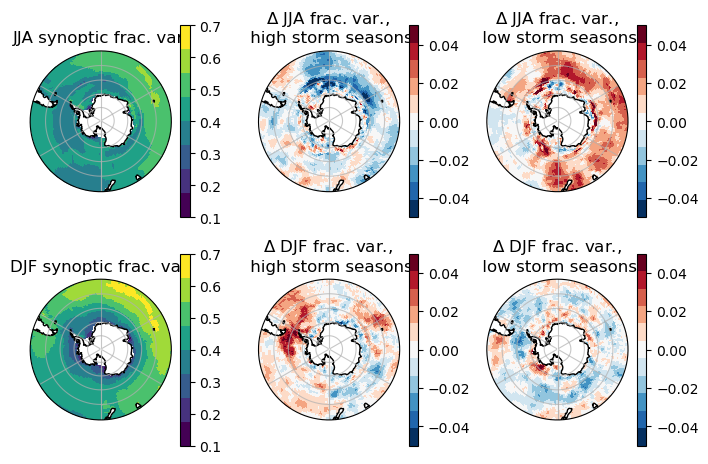

In [44]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
    figsize=(7, 4.8),
)

axs = axs.flatten()

synfrac_jja.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=0.1,
    vmax=0.7,
    extend="neither",
    cmap=plt.get_cmap("viridis", 8),
)
axs[0].set_title("JJA synoptic frac. var.")

synfrac_djf.plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    vmin=0.1,
    vmax=0.7,
    extend="neither",
    cmap=plt.get_cmap("viridis", 8),
)
axs[3].set_title("DJF synoptic frac. var.")

(synfrac_jja_hi - synfrac_jja).plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmin=-0.05,
    vmax=0.05,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[1].set_title("$\Delta$ JJA frac. var., \n high storm seasons")

(synfrac_jja_lo - synfrac_jja).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    vmin=-0.05,
    vmax=0.05,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[2].set_title("$\Delta$ JJA frac. var., \n low storm seasons")


((synfrac_djf_hi - synfrac_djf)).plot(
    ax=axs[4],
    transform=ccrs.PlateCarree(),
    vmin=-0.05,
    vmax=0.05,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[4].set_title("$\Delta$ DJF frac. var., \n high storm seasons")

((synfrac_djf_lo - synfrac_djf)).plot(
    ax=axs[5],
    transform=ccrs.PlateCarree(),
    vmin=-0.05,
    vmax=0.05,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[5].set_title("$\Delta$ DJF frac. var., \n low storm seasons")

for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.1

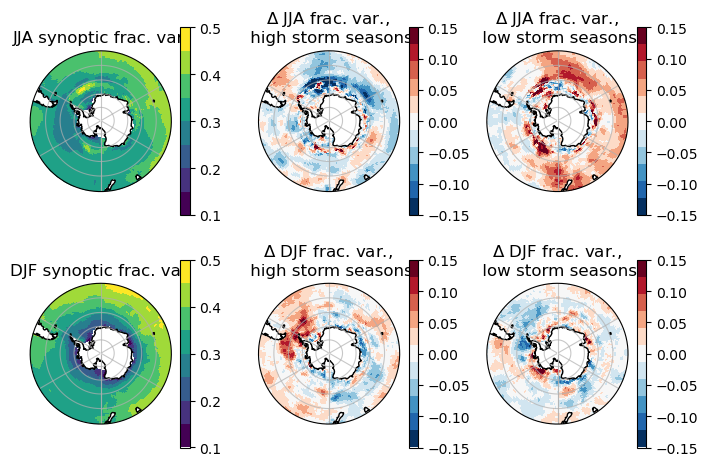

In [22]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
    figsize=(7, 4.8),
)

axs = axs.flatten()

synfrac_jja.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=0.1,
    vmax=0.5,
    extend="neither",
    cmap=plt.get_cmap("viridis", 8),
)
axs[0].set_title("JJA synoptic frac. var.")

synfrac_djf.plot(
    ax=axs[3],
    transform=ccrs.PlateCarree(),
    vmin=0.1,
    vmax=0.5,
    extend="neither",
    cmap=plt.get_cmap("viridis", 8),
)
axs[3].set_title("DJF synoptic frac. var.")

((synfrac_jja_hi - synfrac_jja) / synfrac_jja).plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmin=-0.15,
    vmax=0.15,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[1].set_title("$\Delta$ JJA frac. var., \n high storm seasons")

((synfrac_jja_lo - synfrac_jja) / synfrac_jja).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    vmin=-0.15,
    vmax=0.15,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[2].set_title("$\Delta$ JJA frac. var., \n low storm seasons")


((synfrac_djf_hi - synfrac_djf) / synfrac_djf).plot(
    ax=axs[4],
    transform=ccrs.PlateCarree(),
    vmin=-0.15,
    vmax=0.15,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[4].set_title("$\Delta$ DJF frac. var., \n high storm seasons")

((synfrac_djf_lo - synfrac_djf) / synfrac_djf).plot(
    ax=axs[5],
    transform=ccrs.PlateCarree(),
    vmin=-0.15,
    vmax=0.15,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 11),
)
axs[5].set_title("$\Delta$ DJF frac. var., \n low storm seasons")

for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()